In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
import nltk.data

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [35]:
# read the dataset
reviews_data = pd.read_json(r"C:\Users\user\Documents\UoM\Thesis\data\Clothing_Shoes_and_Jewelry_5.json", lines=True)

# Keep only the review text and the grade
reviews_data = reviews_data[['overall', 'reviewText']]


# Drop the products whose values are null
reviews_data = reviews_data[reviews_data['reviewText'].notna()]

In [36]:
ratings = []
for index,entry in enumerate(reviews_data['overall']):
    if entry == 1.0 or entry == 2.0:
        ratings.append(-1)
    elif entry == 3.0:
        ratings.append(0)
    elif entry == 4.0 or entry == 5.0:
        ratings.append(1)

In [37]:
""""
Split each review into sentences
and preprocess each sentence
"""
stopwords = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()

preprocessed_data = []
index = 0
for review in reviews_data['reviewText']:
    if(index % 10000 == 0):
        print(index)
    review_sentences = tokenizer.tokenize(review)
    for sentence in review_sentences:
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        sentence = sentence.lower()
        sentence = word_tokenize(sentence)
        sentence = [wordnet_lemmatizer.lemmatize(word) for word in sentence]
        sentence = ' '.join(sentence)
        if(sentence != ''):
            review = {}
            review["index"] = index
            review["sentence"] = sentence
            review["rating"] = ratings[index]
            preprocessed_data.append(review)
    index += 1

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000


In [38]:
print("Before preprocessing: ", reviews_data['reviewText'][278643])
print("------------------------------------------------")
print("After preprocessing: ", [d for d in preprocessed_data if d['index'] == 278643])
print(len(preprocessed_data))

Before preprocessing:  idk why this shirt didnt fit i mean i ordered an Xlits very short and it seems like it was cut weird because the cross sits funny, like sideways.also one of the studs fell off the second i tried it on. ahhhhhhh whatever thats what i get for ordering clothes online loli DO NOT recommend
------------------------------------------------
After preprocessing:  [{'index': 278643, 'sentence': 'idk why this shirt didnt fit i mean i ordered an xlits very short and it seems like it wa cut weird because the cross sits funny like sideways also one of the stud fell off the second i tried it on', 'rating': -1}, {'index': 278643, 'sentence': 'ahhhhhhh whatever thats what i get for ordering clothes online loli do not recommend', 'rating': -1}]
1175245


In [39]:
df = pd.DataFrame(preprocessed_data)

In [40]:
analyzer = SentimentIntensityAnalyzer()

def calculate_vader_score(sentence):
    scores_dict = analyzer.polarity_scores(sentence)
    return scores_dict['compound']

In [41]:
review = [d for d in preprocessed_data if d['index'] == 234584]
print(review)
for sentence in review:
    print(calculate_vader_score(sentence['sentence']))
print(calculate_vader_score(reviews_data['reviewText'][234584]))

[{'index': 234584, 'sentence': 'the color in the picture doesn t do the sandal justice', 'rating': 1}, {'index': 234584, 'sentence': 'they are a beautiful beige taupe sandal', 'rating': 1}, {'index': 234584, 'sentence': 'the faux patent leather add a nice shine', 'rating': 1}, {'index': 234584, 'sentence': 'the buckle on top is a brushed silver which add just the right amount of flare', 'rating': 1}, {'index': 234584, 'sentence': 'what s great about these sandal is they aren t completely flat for those with arch problem', 'rating': 1}, {'index': 234584, 'sentence': 'they have just the right heal height about an inch', 'rating': 1}, {'index': 234584, 'sentence': 'they also have just the right amount of cushion', 'rating': 1}, {'index': 234584, 'sentence': 'the center strap is a little tight on my foot but will hopefully get loser with wear', 'rating': 1}, {'index': 234584, 'sentence': 'cute sandal', 'rating': 1}]
0.5267
0.5994
0.4215
0.2023
0.34
0.0
0.0
-0.2617
0.4588
0.8718


In [42]:
def get_sentiment_from_score(predicted_score):
    if predicted_score > 0:
        return 1
    elif predicted_score < 0:
        return -1
    else:
        return 0

In [43]:
# Calculate predicted scores using afinn lexicon approcach
df['predicted_score'] = df.apply(lambda x: calculate_vader_score(x['sentence']), axis=1)

# Get the sentiment from the caluclated score
df['predicted_sentiment'] = df.apply(lambda x: get_sentiment_from_score(x['predicted_score']), axis=1)

In [44]:
df.head()

,index,sentence,rating,predicted_score,predicted_sentiment
0,0,this is a great tutu and at a really great price,1,0.8588,1
1,0,it doesn t look cheap at all,1,0.0000,0
2,0,i m so glad i looked on amazon and found such ...,1,0.6774,1
3,0,a,1,0.0000,0
4,1,i bought this for my yr old daughter for dance...,1,0.4939,1


In [45]:
def find_Max_Element(scores):
    c = Counter(scores)
    negatives = c[-1]
    neutral = c[0]
    positives = c[1]
    
    if(scores[0] == -1):
        negatives += 1
    elif(scores[0] == 0):
        neutral += 1
    elif(scores[0] == 1):
        positives += 1
    
    
    if(scores[-1] == -1):
        negatives += 1
    elif(scores[-1] == 0):
        neutral += 1
    elif(scores[-1] == 1):
        positives += 1

    if(neutral == positives and neutral > negatives and positives > negatives):
        max_element = 1
    elif (neutral == negatives and neutral > positives and negatives > positives):
        max_element = -1
    elif (neutral == negatives and negatives == positives):
        max_element = 0
    elif (positives == negatives and positives > neutral and negatives > neutral) :
        max_element = 0
    else:
        max_element = max(set(scores), key = scores.count)
        
    return max_element


Accuracy:  73.71214676897237
----------------------
              precision    recall  f1-score   support

    Negative       0.47      0.24      0.32     26652
     Neutral       0.18      0.26      0.22     30422
    Positive       0.86      0.86      0.86    221568

    accuracy                           0.74    278642
   macro avg       0.51      0.45      0.46    278642
weighted avg       0.75      0.74      0.74    278642



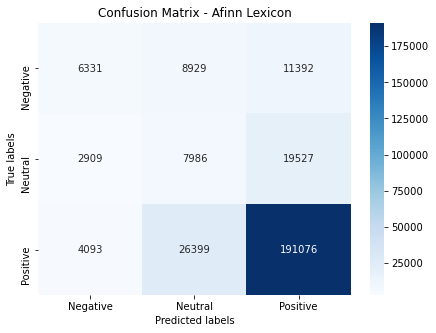

In [46]:
# Report 

# for each review get all scores by review
scores_by_review_frame = df.groupby('index')['predicted_sentiment'].apply(list)
majority_scores =  scores_by_review_frame.apply(find_Max_Element)
predicted_scores = list(majority_scores)

# for each review get its actual score
actual_scores_frame = df.groupby('index')['rating'].first()
actual_scores = list(actual_scores_frame)

# get all indexes
review_indexes = df['index'].unique()

# Calculate Accuracy
accuracy = accuracy_score(predicted_scores, actual_scores)*100
print("Accuracy: ", accuracy)
print("----------------------")

# Confusion Matrix
cm = confusion_matrix(actual_scores, predicted_scores)
cm = confusion_matrix(actual_scores, predicted_scores)
plt.figure(figsize = (7,5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Afinn Lexicon')
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']) 
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])

# Classification Report
my_tags = ['Negative','Neutral','Positive']
print(classification_report(actual_scores, predicted_scores, target_names=my_tags))
report = classification_report(actual_scores, predicted_scores, target_names=my_tags, output_dict=True);
clsf_report = pd.DataFrame(report).transpose()
clsf_report.to_csv('reports/Lexicon_Based_Vader.csv', index= True)

In [47]:
# write indexes of false classified reviews to a txt file

data = {"review_index": review_indexes, "predict": predicted_scores, "actual": actual_scores}

review_dataframe = pd.DataFrame(data)

false_classified_indexes = review_dataframe['review_index'][review_dataframe['predict'] != review_dataframe['actual']]
false_classified_indexes = list(false_classified_indexes)

with open("indexes/Lexicon_Based_Vader.txt", 'w') as f:
    for item in false_classified_indexes:
        f.write("%s\n" % item)
        
        # save those indexes who are predicted as negative but they are neutral
negativePredicted_neutralActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == -1) & (review_dataframe['actual'] == 0)]
negativePredicted_neutralActual_indexes = list(negativePredicted_neutralActual_indexes)
with open("indexes/Lexicon_Based_Vader_NegativePredicted_NeutralActual.txt", 'w') as f:
    for item in negativePredicted_neutralActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as negative but they are positive
negativePredicted_positiveActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == -1) & (review_dataframe['actual'] == 1)]
negativePredicted_positiveActual_indexes = list(negativePredicted_positiveActual_indexes)
with open("indexes/Lexicon_Based_Vader_NegativePredicted_PositiveActual.txt", 'w') as f:
    for item in negativePredicted_positiveActual_indexes:
        f.write("%s\n" % item)
        
# save those indexes who are predicted as neutral but they are negative
neutralPredicted_negativeActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] ==0) & (review_dataframe['actual'] == -1)]
neutralPredicted_negativeActual_indexes = list(neutralPredicted_negativeActual_indexes)
with open("indexes/Lexicon_Based_Vader_NeutralPredicted_NegativeActual.txt", 'w') as f:
    for item in neutralPredicted_negativeActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as neutral but they are positive
neutralPredicted_positiveActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] ==0) & (review_dataframe['actual'] == 1)]
neutralPredicted_positiveActual_indexes = list(neutralPredicted_positiveActual_indexes)
with open("indexes/Lexicon_Based_Vader_NeutralPredicted_PositiveActual.txt", 'w') as f:
    for item in neutralPredicted_positiveActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as positive but they are negative        
positivePredicted_negativeActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] ==1) & (review_dataframe['actual'] == -1)]
positivePredicted_negativeActual_indexes = list(positivePredicted_negativeActual_indexes)
with open("indexes/Lexicon_Based_Vader_PositivePredicted_NegativeActual.txt", 'w') as f:
    for item in positivePredicted_negativeActual_indexes:
        f.write("%s\n" % item)
 
# save those indexes who are predicted as positive but they are neutral 
positivePredicted_neutralActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] ==1) & (review_dataframe['actual'] == 0)]
positivePredicted_neutralActual_indexes = list(positivePredicted_neutralActual_indexes)
with open("indexes/Lexicon_Based_Vader_PositivePredicted_NeutralActual.txt", 'w') as f:
    for item in positivePredicted_neutralActual_indexes:
        f.write("%s\n" % item)